### **Notebook to run StellarStats bulk analysis**

##### **Segment in batch:**

Provide your image directory, assuming all tiff files are lambda scans and your metadata is collected in a folder called `MetaData`. \
You might have to edit the file names for analysis, since naming conventions change based on method of image export, look in the `stellarstats_analyse_batch.py` at lines 64 & 67.

In [148]:
input_dir = "/scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440"

In [149]:
%run stellarstats_segment_batch.py -i {input_dir} --use_gpu 

Processing file: /scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440/230630_FRL+WL_Cthrm_G1_lmda_440_tau.tif
MIP file already exists: /scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440/MIPs/230630_FRL+WL_Cthrm_G1_lmda_440_tau_MIP.tif. Skipping projection.
Segmentation saved to /scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440/Masks/230630_FRL+WL_Cthrm_G1_lmda_440_tau_MIP.npy and /scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440/Masks/230630_FRL+WL_Cthrm_G1_lmda_440_tau_MIP.png
Segmentation saved for /scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440/230630_FRL+WL_Cthrm_G1_lmda_440_tau.tif
Processing file: /scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440/230630_FRL+WL_Cthrm_G1_pos3_440_3nm_20nm.tif
MIP file already exists: /

In [151]:
%run stellarstats_analyse_batch.py -p {input_dir}  --plot_normalized_intensity --shape_metrics  --save_output

Processing file: 230630_FRL+WL_Cthrm_G1_pos2_440_3nm_20nm_MIP_seg.npy
Saved cell sizes to /scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440/combined_cell_sizes.csv
Processing file: 230630_FRL+WL_Cthrm_G1_pos3_440_3nm_20nm_MIP_seg.npy
Saved cell sizes to /scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440/combined_cell_sizes.csv
Saved combined intensity data to /scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440/combined_intensity_data.csv
Saved normalized combined intensity plot to /scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD003_Ctherm/LM/Lambdas/Mix/230630_MIX/440/normalized_combined_intensity_plot.svg


##### **Optimize segmentation parameters**

Values of interest for the segmentation are:

- diameter: default is None, which let's programme detect size by itself, but can be overwritten to force cell diameter. Provide in pixels.
- flow_threshold: threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded)
- cell_prob_threshold: threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6))

Saved MIP image to /scicore/home/engel0006/vandor0000/script_library/CLEM/stellarstats/trials/MIPs/241211_ST1_5.1_G1_Series003_MIP.tif


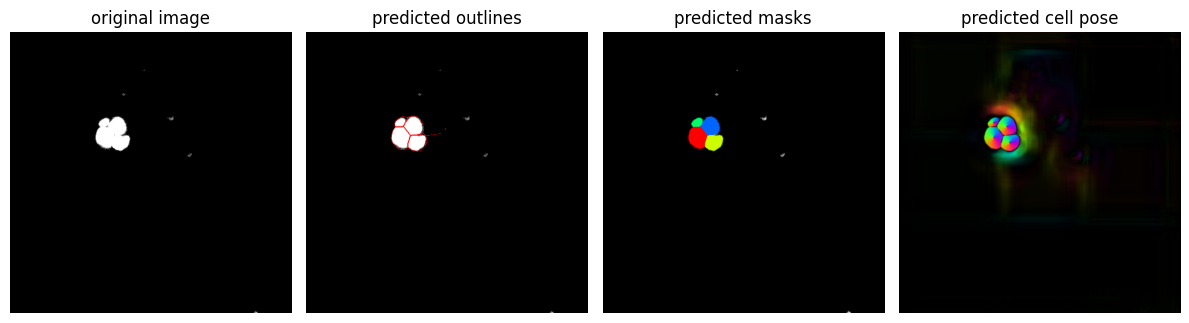

In [2]:
%run stellarstats_segment_single.py --tiff "/scicore/home/engel0006/vandor0000/script_library/CLEM/stellarstats/trials/241211_ST1_5.1_G1_Series003.tif"  --trial 

In [ ]:
%run stellarstats_analyse_single.py -p "/scicore/home/engel0006/vandor0000/script_library/CLEM/stellarstats/trials" -i "/scicore/home/engel0006/vandor0000/script_library/CLEM/stellarstats/trials/241211_ST1_5.1_G1_Series003.tif" -m "/scicore/home/engel0006/vandor0000/script_library/CLEM/stellarstats/trials/MetaData/241211_ST1_5.1_G1_Series003_Properties.xml"  --save_output

In [ ]:
%run stellarstats_segment_single.py --help

In [ ]:
%run stellarstats_analyse_batch.py -p "/scicore/home/engel0006/vandor0000/script_library/CLEM/stellarstats/trials" --save_output

#### **Manon's scripts**

In [ ]:
pip install scikit-image

In [ ]:
import os
import numpy as np
import tifffile as tf
from cellpose import models
import random
import pandas as pd
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import cv2  # For contrast enhancement

In [ ]:
#Configuration
input_file = '/scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD006_AmarinaFaRLiP/LM/250314_Ama_FRL_2.6/440/250314_Ama_FRL_2.6_Image 1.tif' 
output_dir = "/scicore/home/engel0006/GROUP/pool-engel/Sofie/CLEM/SvD006_AmarinaFaRLiP/LM/250314_Ama_FRL_2.6/440/tile_test"
os.makedirs(output_dir, exist_ok=True)

#Load the TIFF file and create a Maximum Intensity Projection (MIP)
with tf.TiffFile(input_file) as tif:
    images = tif.asarray()
    selected_frames = images[0:80]  # Use frames 1-80 for MIP

#Calculate the MIP
mip = np.max(selected_frames, axis=0)
mip_output_file = os.path.join(output_dir, 'MIP_image.tif')
tf.imwrite(mip_output_file, mip, photometric='minisblack')  # Save as TIFF
print(f"Saved MIP to {mip_output_file}")

#Apply contrast enhancement (Sequential CLAHE followed by Histogram Equalization)
#Step 1: CLAHE (Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
mip_clahe = clahe.apply(np.uint8(mip))

#Step 2: Histogram Equalization
enhanced_mip = cv2.equalizeHist(mip_clahe)

#Save the enhanced image
enhanced_output_file = os.path.join(output_dir, 'Enhanced_MIP_image.tif')
tf.imwrite(enhanced_output_file, enhanced_mip, photometric='minisblack')
print(f"Saved enhanced MIP to {enhanced_output_file}")

#Display the original and enhanced MIP
plt.figure(figsize=(10, 5))

#Original MIP
plt.subplot(1, 2, 1)
plt.imshow(mip, cmap='gray')
plt.title("Original MIP")
plt.axis('off')

#Enhanced MIP
plt.subplot(1, 2, 2)
plt.imshow(enhanced_mip, cmap='gray')
plt.title("Enhanced MIP")
plt.axis('off')

plt.show()

In [ ]:
# Configuration
output_dir = "/scicore/home/engel0006/GROUP/pool-engel/Sofie/CLEM/SvD006_AmarinaFaRLiP/LM/250314_Ama_FRL_2.6/440/tile_test"
mip_file = "/scicore/home/engel0006/vandor0000/Sofie_data/CLEM/SvD006_AmarinaFaRLiP/LM/250314_Ama_FRL_2.6/440/MIPs/250314_Ama_FRL_2.6_Image 1_MIP.tif"
channels = [0, 0]  # Set channels for CellPose
num_tiles = 20  # Number of tiles along each axis (total tiles = num_tiles^2)
min_size = 0.0001  # Minimum size for a cell (in pixels)
max_size = 30000  # Maximum size for a cell (in pixels)
low_threshold = 0.35  # CellPose low threshold
cellprob_threshold = 0.1  # CellPose cell probability threshold
 
# Load the MIP image
mip = tf.imread(mip_file)
 
# Split the MIP into tiles
height, width = mip.shape
tile_height = height // num_tiles
tile_width = width // num_tiles
 
# Initialize the Cellpose model
model = models.Cellpose(gpu=False, model_type='cyto3')
 
# Prepare for segmentation
all_masks = np.zeros_like(mip, dtype=np.uint16)  # To store all masks
current_label = 1  # Start labeling cells from 1
cell_data = []  # To store data for the final table
 
# Function to display tiles and segmentation
def display_image(image, title, cmap=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()
 
# Process each tile
for i in range(num_tiles):
    for j in range(num_tiles):
        # Extract the tile
        start_x, end_x = j * tile_width, (j + 1) * tile_width
        start_y, end_y = i * tile_height, (i + 1) * tile_height
        tile = mip[start_y:end_y, start_x:end_x]
 
        # Perform segmentation on the tile
        masks, flows, styles, diams = model.eval(
            tile,
            diameter=None,
            channels=channels,
            flow_threshold=low_threshold,
            cellprob_threshold=cellprob_threshold
        )
 
        # Filter cells by size
        labeled_tile = label(masks)
        filtered_masks = np.zeros_like(masks, dtype=np.uint16)
        for region in regionprops(labeled_tile):
            if min_size <= region.area <= max_size:
                filtered_masks[labeled_tile == region.label] = current_label
                # Collect cell data
                cell_data.append({
                    "Cell ID": current_label,
                    "Cell Width": region.major_axis_length,
                    "Cell Number": len(cell_data) + 1  # Row number
                })
                current_label += 1
 
        # Add the filtered masks back to the global mask
        all_masks[start_y:end_y, start_x:end_x] = filtered_masks
 
        # Display the tile and its segmentation
        #display_image(tile, f"Tile ({i}, {j}) - MIP", cmap="gray")
        #display_image(filtered_masks, f"Tile ({i}, {j}) - Segmentation", cmap="viridis")
 
# Save the segmentation results as an image (convert to uint8 for visualization)
masks_uint8 = (all_masks > 0).astype(np.uint8) * 255  # Create a binary mask
segmentation_output_file = os.path.join(output_dir, 'segmentation_results.png')
tf.imwrite(segmentation_output_file, masks_uint8, photometric='minisblack')  # Save as TIFF for consistency
 
# Save all_masks as uint16 for further analysis
segmentation_output_uint16 = os.path.join(output_dir, 'segmentation_results_uint16.tif')
tf.imwrite(segmentation_output_uint16, all_masks, photometric='minisblack')
 
print(f"Segmentation results saved to {segmentation_output_file}")
print(f"Segmentation masks (uint16) saved to {segmentation_output_uint16}")
 
# Create a DataFrame for the cell data
cell_data_df = pd.DataFrame(cell_data)
 
# Save the table as a CSV file
cell_data_csv_output_file = os.path.join(output_dir, 'cell_data.csv')
cell_data_df.to_csv(cell_data_csv_output_file, index=False)
print(f"Cell data saved to {cell_data_csv_output_file}")
 
# Visualization Function
def display_rgb_image(image, title):
    """Display an RGB image."""
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()
 
# Load the saved TIFF for visualization
colored_segmentation_output_file = os.path.join(output_dir, 'segmentation_results.png')
colored_segmentation_loaded = tf.imread(colored_segmentation_output_file)
 
# Display the colored segmentation
display_rgb_image(colored_segmentation_loaded, "Colored Segmentation (TIFF)")